# SENTIMENT ANALYSIS

#Libraries inports and initial setup

In [42]:
import numpy as np
import pandas as pd
import tensorflow as tf
import warnings
from keras.layers import Embedding, LSTM, GRU, Conv1D, GlobalMaxPooling1D, Dense, Bidirectional, SimpleRNN, MultiHeadAttention, Dropout, LayerNormalization, Input
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
warnings.filterwarnings("ignore")
import re, string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk, subprocess
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Pre-processing

##Loading the dataset

In [75]:
from google.colab import drive
drive.mount('/content/drive')
dataset_path = '/content/drive/My Drive/Positive_or_Negative/IMDB_dataset.csv'
df = pd.read_csv(dataset_path)
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## Plotting the labels of the dataset: positive and negative

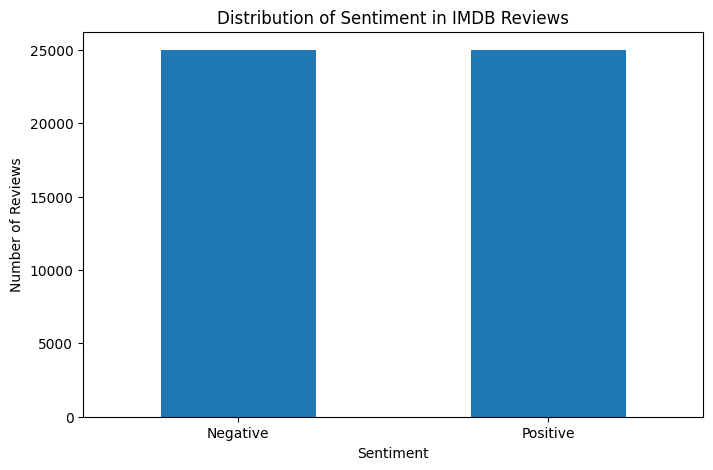

In [44]:
# Count the number of positive and negative reviews
sentiment_counts = df['sentiment'].value_counts()

# Plotting
plt.figure(figsize=(8, 5))
sentiment_counts.plot(kind='bar')
plt.title('Distribution of Sentiment in IMDB Reviews')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.xticks(ticks=[0, 1], labels=['Negative', 'Positive'], rotation=0)  # Adjust as needed based on your sentiment mapping
plt.show()

## Converting textual labels into a numerical format

In [45]:
# Positive=1 or Negative=0
df["sentiment"].loc[df["sentiment"]=="positive"]=1
df["sentiment"].loc[df["sentiment"]=="negative"]=0
df["sentiment"] = np.asarray(df["sentiment"]).astype("int")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


## Removing special characters and transforming upper case letters into lower case letters

In [46]:
# Remove special characters from the "review" column
df['review'] = df['review'].apply(lambda x: re.sub(r'[^A-Za-z0-9 ]+', '', x))
# Convert all characters in the "review" column to lowercase
df['review'] = df['review'].str.lower()


In [47]:
# Extract out sentences and labels
sentences = df['review']
labels = df['sentiment']
sentences

0        one of the other reviewers has mentioned that ...
1        a wonderful little production br br the filmin...
2        i thought this was a wonderful way to spend ti...
3        basically theres a family where a little boy j...
4        petter matteis love in the time of money is a ...
                               ...                        
49995    i thought this movie did a down right good job...
49996    bad plot bad dialogue bad acting idiotic direc...
49997    i am a catholic taught in parochial elementary...
49998    im going to have to disagree with the previous...
49999    no one expects the star trek movies to be high...
Name: review, Length: 50000, dtype: object

## Tokenization of the dataset

In [48]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    sentences,
    1000,
    max_subword_length=1000
)

In [49]:
# Checking the size of the vocab size
print("Vocab size is ", tokenizer.vocab_size)

Vocab size is  997


In [50]:
# Checking that the tokenizer works appropriately
num = 5
print(sentences[num])
encoded = tokenizer.encode(sentences[num])
print(encoded)

probably my alltime favorite movie a story of selflessness sacrifice and dedication to a noble cause but its not preachy or boring it just never gets old despite my having seen it some 15 or more times in the last 25 years paul lukas performance brings tears to my eyes and bette davis in one of her very few truly sympathetic roles is a delight the kids are as grandma says more like dressedup midgets than children but that only makes them more fun to watch and the mothers slow awakening to whats happening in the world and under her own roof is believable and startling if i had a dozen thumbs theyd all be up for this movie
[626, 194, 20, 168, 54, 469, 640, 10, 84, 251, 34, 128, 29, 3, 197, 5, 641, 235, 630, 356, 2, 65, 650, 109, 89, 4, 47, 704, 343, 773, 6, 3, 140, 160, 72, 405, 773, 28, 59, 36, 227, 180, 845, 12, 42, 686, 17, 14, 115, 473, 345, 2, 609, 773, 268, 135, 128, 168, 102, 505, 466, 14, 138, 790, 794, 773, 42, 161, 522, 2, 9, 1, 97, 79, 791, 794, 773, 445, 2, 103, 236, 773, 266

In [51]:
# Separately print out each subword, decoded
for i in encoded:
  print(tokenizer.decode([i]), end=" ")

prob ab ly  my  al lt im e  fa vo ri te  movie  a  story  of  sel fl ess nes s  sa cri fi ce  and  de dic ation   to  a  no ble  ca use   but  its  not  pre ac h y  or  bor ing  it  just  never  get s  old   des pi te  my  ha ving  seen  it  some  1 5   or  more  time s  in  the  la st  2 5   year s  pa ul   lu ka s  perform ance   bri ng s  tea rs  to  my  ey es  and  bet te  da vi s  in  one  of  her  very  fe w  tru ly  sy mp at he tic   rol es  is  a  de li ght  the  ki ds  are  as  gra nd ma   sa ys  more  like  dr ess ed up  mi d get s  than  chi ld ren   but  that  only  make s  them  more  fu n  to  watch  and  the  mo ther s  sl ow   aw ak en ing  to  wh at s  happ en ing  in  the  wor ld  and  under   her  own  ro of  is  belie va ble  and  star tl ing  if  i  had  a  do ze n  th um b s  the y d  all  be  up  for  this  mov ie 

In [52]:
for i, sentence in enumerate(sentences):
  sentences[i] = tokenizer.encode(sentence)

## Last step of pre-processing, prepare train and test

In [53]:
max_length = 50
trunc_type='post'
padding_type='post'

# Pad all sequences
sequences_padded = pad_sequences(sentences, maxlen=max_length,
                                 padding=padding_type, truncating=trunc_type)

# Separate out the sentences and labels into training and test sets
training_size = int(len(sentences) * 0.8)

training_sequences = sequences_padded[0:training_size]
testing_sequences = sequences_padded[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

# Make labels into numpy arrays for use with the network later
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)

# Training Testing and Evaluation

## Creation of multiple models

In [54]:
# Constants
embedding_dim = 16
vocab_size = 1000

# Function to create models
def create_model(model_type, vocab_size, embedding_dim, max_length):
    input_layer = Input(shape=(max_length,))
    embedding_layer = Embedding(vocab_size, embedding_dim, input_length=max_length)(input_layer)

    if model_type == 'LSTM':
        x = Bidirectional(LSTM(embedding_dim, return_sequences=True))(embedding_layer)
        x = Bidirectional(LSTM(embedding_dim))(x)
    elif model_type == 'GRU':
        x = Bidirectional(GRU(embedding_dim, return_sequences=True))(embedding_layer)
        x = Bidirectional(GRU(embedding_dim))(x)
    elif model_type == 'Conv1D':
        x = Conv1D(128, 5, activation='relu')(embedding_layer)
        x = GlobalMaxPooling1D()(x)
    elif model_type == 'SimpleRNN':
        x = SimpleRNN(embedding_dim, return_sequences=True)(embedding_layer)
        x = SimpleRNN(embedding_dim)(x)
    elif model_type == 'Transformer':
        attn_output = MultiHeadAttention(num_heads=2, key_dim=embedding_dim)(embedding_layer, embedding_layer)
        attn_output = Dropout(0.1)(attn_output)
        x = LayerNormalization(epsilon=1e-6)(embedding_layer + attn_output)
        x = Dense(embedding_dim, activation='relu')(x)
        x = Dense(embedding_dim)(x)
        x = Dropout(0.1)(x)
        x = LayerNormalization(epsilon=1e-6)(x + attn_output)
        x = GlobalMaxPooling1D()(x)
    else:
        raise ValueError("Unsupported model type")

    dense_layer = Dense(6, activation='relu')(x)
    output_layer = Dense(1, activation='sigmoid')(dense_layer)

    model = Model(inputs=input_layer, outputs=output_layer)
    return model

## Function to train and evaluate models and also show the confusion matrix for each model

In [68]:
# Train and evaluate models
def train_and_evaluate(model_type, training_sequences, training_labels_final, testing_sequences, testing_labels_final):
    print(f"Processing model: {model_type}")
    model = create_model(model_type, vocab_size, embedding_dim, max_length)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    history = model.fit(training_sequences, training_labels_final, epochs=10, validation_data=(testing_sequences, testing_labels_final), verbose=1)
    val_accuracy = max(history.history['val_accuracy'])
    print(f"Finished training {model_type}. Best Validation Accuracy: {val_accuracy}")

    # Predict and plot confusion matrix
    predictions = model.predict(testing_sequences)
    predicted_labels = (predictions > 0.5).astype(int).flatten()
    cm = confusion_matrix(testing_labels_final, predicted_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {model_type}')
    plt.show()

    return history, val_accuracy

## Testing each model and plotting the Confusion matrix

Processing model: LSTM
Epoch 1/10
1250/1250 [==============================] - 76s 54ms/step - loss: 0.6080 - accuracy: 0.6560 - val_loss: 0.5790 - val_accuracy: 0.6841
Epoch 2/10
1250/1250 [==============================] - 65s 52ms/step - loss: 0.5585 - accuracy: 0.7030 - val_loss: 0.5640 - val_accuracy: 0.6951
Epoch 3/10
1250/1250 [==============================] - 63s 51ms/step - loss: 0.5395 - accuracy: 0.7159 - val_loss: 0.5582 - val_accuracy: 0.6962
Epoch 4/10
1250/1250 [==============================] - 61s 49ms/step - loss: 0.5261 - accuracy: 0.7232 - val_loss: 0.5545 - val_accuracy: 0.7013
Epoch 5/10
1250/1250 [==============================] - 63s 50ms/step - loss: 0.5143 - accuracy: 0.7324 - val_loss: 0.5571 - val_accuracy: 0.6938
Epoch 6/10
1250/1250 [==============================] - 61s 49ms/step - loss: 0.5065 - accuracy: 0.7388 - val_loss: 0.5525 - val_accuracy: 0.7022
Epoch 7/10
1250/1250 [==============================] - 64s 51ms/step - loss: 0.4956 - accuracy: 0.74

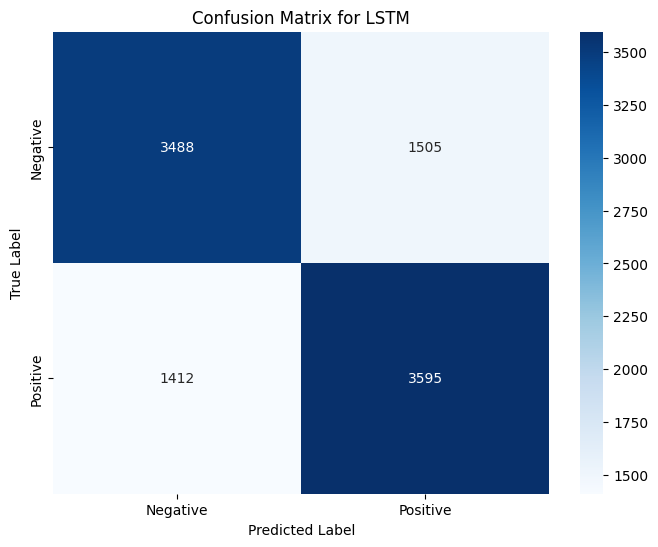

Processing model: GRU
Epoch 1/10
1250/1250 [==============================] - 72s 52ms/step - loss: 0.6214 - accuracy: 0.6411 - val_loss: 0.5885 - val_accuracy: 0.6884
Epoch 2/10
1250/1250 [==============================] - 61s 49ms/step - loss: 0.5643 - accuracy: 0.6988 - val_loss: 0.5752 - val_accuracy: 0.6770
Epoch 3/10
1250/1250 [==============================] - 63s 50ms/step - loss: 0.5413 - accuracy: 0.7117 - val_loss: 0.5481 - val_accuracy: 0.7009
Epoch 4/10
1250/1250 [==============================] - 63s 50ms/step - loss: 0.5244 - accuracy: 0.7239 - val_loss: 0.5436 - val_accuracy: 0.7033
Epoch 5/10
1250/1250 [==============================] - 64s 51ms/step - loss: 0.5091 - accuracy: 0.7355 - val_loss: 0.5391 - val_accuracy: 0.7088
Epoch 6/10
1250/1250 [==============================] - 62s 50ms/step - loss: 0.4953 - accuracy: 0.7426 - val_loss: 0.5449 - val_accuracy: 0.7118
Epoch 7/10
1250/1250 [==============================] - 62s 50ms/step - loss: 0.4847 - accuracy: 0.752

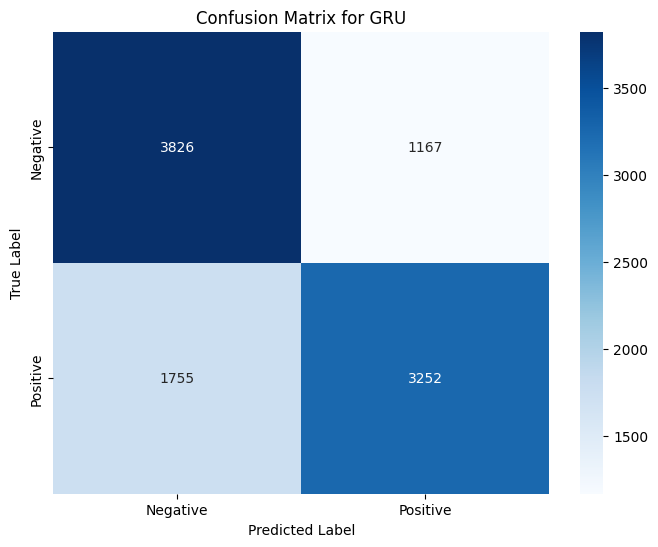

Processing model: Conv1D
Epoch 1/10
1250/1250 [==============================] - 11s 8ms/step - loss: 0.6055 - accuracy: 0.6517 - val_loss: 0.5688 - val_accuracy: 0.6925
Epoch 2/10
1250/1250 [==============================] - 10s 8ms/step - loss: 0.5344 - accuracy: 0.7249 - val_loss: 0.5507 - val_accuracy: 0.7112
Epoch 3/10
1250/1250 [==============================] - 8s 6ms/step - loss: 0.4977 - accuracy: 0.7525 - val_loss: 0.5451 - val_accuracy: 0.7159
Epoch 4/10
1250/1250 [==============================] - 9s 7ms/step - loss: 0.4631 - accuracy: 0.7791 - val_loss: 0.5511 - val_accuracy: 0.7183
Epoch 5/10
1250/1250 [==============================] - 9s 7ms/step - loss: 0.4301 - accuracy: 0.7998 - val_loss: 0.5626 - val_accuracy: 0.7202
Epoch 6/10
1250/1250 [==============================] - 8s 7ms/step - loss: 0.3952 - accuracy: 0.8213 - val_loss: 0.5768 - val_accuracy: 0.7150
Epoch 7/10
1250/1250 [==============================] - 10s 8ms/step - loss: 0.3622 - accuracy: 0.8398 - val_

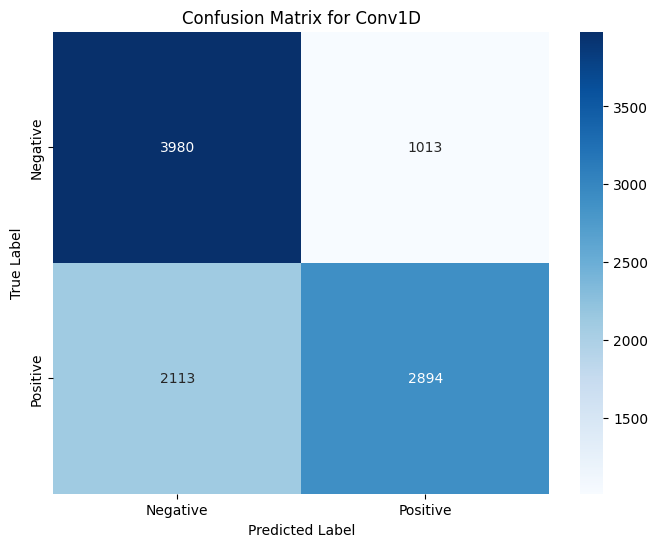

Processing model: SimpleRNN
Epoch 1/10
1250/1250 [==============================] - 30s 23ms/step - loss: 0.6940 - accuracy: 0.5054 - val_loss: 0.6920 - val_accuracy: 0.5168
Epoch 2/10
1250/1250 [==============================] - 27s 21ms/step - loss: 0.6420 - accuracy: 0.6309 - val_loss: 0.6037 - val_accuracy: 0.6790
Epoch 3/10
1250/1250 [==============================] - 27s 21ms/step - loss: 0.5954 - accuracy: 0.6846 - val_loss: 0.5985 - val_accuracy: 0.6776
Epoch 4/10
1250/1250 [==============================] - 28s 22ms/step - loss: 0.5829 - accuracy: 0.6962 - val_loss: 0.6051 - val_accuracy: 0.6747
Epoch 5/10
1250/1250 [==============================] - 28s 22ms/step - loss: 0.5687 - accuracy: 0.7059 - val_loss: 0.6123 - val_accuracy: 0.6821
Epoch 6/10
1250/1250 [==============================] - 28s 22ms/step - loss: 0.5571 - accuracy: 0.7152 - val_loss: 0.6132 - val_accuracy: 0.6703
Epoch 7/10
1250/1250 [==============================] - 27s 21ms/step - loss: 0.5465 - accuracy:

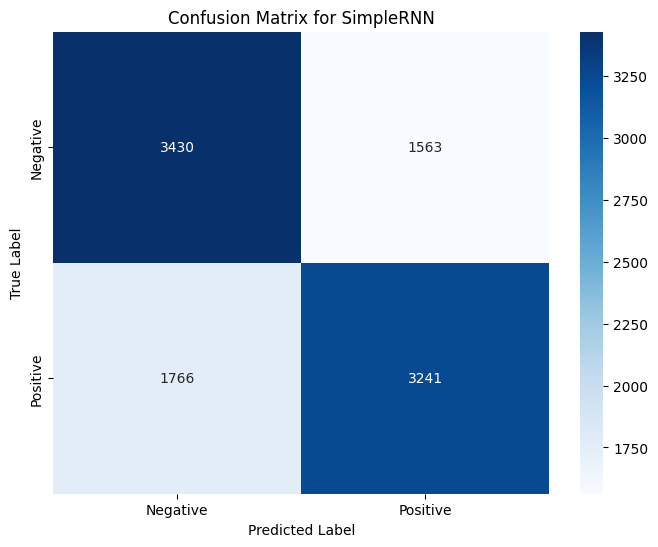

Processing model: Transformer
Epoch 1/10
1250/1250 [==============================] - 24s 15ms/step - loss: 0.6487 - accuracy: 0.6141 - val_loss: 0.6042 - val_accuracy: 0.6681
Epoch 2/10
1250/1250 [==============================] - 20s 16ms/step - loss: 0.5963 - accuracy: 0.6775 - val_loss: 0.5897 - val_accuracy: 0.6785
Epoch 3/10
1250/1250 [==============================] - 19s 15ms/step - loss: 0.5825 - accuracy: 0.6894 - val_loss: 0.6066 - val_accuracy: 0.6626
Epoch 4/10
1250/1250 [==============================] - 19s 16ms/step - loss: 0.5761 - accuracy: 0.6948 - val_loss: 0.5844 - val_accuracy: 0.6864
Epoch 5/10
1250/1250 [==============================] - 20s 16ms/step - loss: 0.5742 - accuracy: 0.6947 - val_loss: 0.5814 - val_accuracy: 0.6881
Epoch 6/10
1250/1250 [==============================] - 18s 14ms/step - loss: 0.5701 - accuracy: 0.6987 - val_loss: 0.5837 - val_accuracy: 0.6865
Epoch 7/10
1250/1250 [==============================] - 20s 16ms/step - loss: 0.5691 - accurac

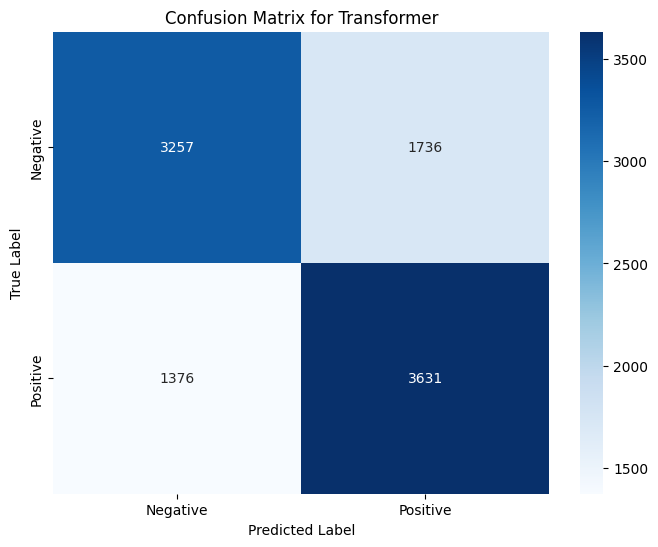

In [69]:
model_types = ['LSTM', 'GRU', 'Conv1D', 'SimpleRNN', 'Transformer']

model_histories = {}
model_accuracies = {}

for model_type in model_types:
    history, val_accuracy = train_and_evaluate(model_type, training_sequences, training_labels_final, testing_sequences, testing_labels_final)
    model_histories[model_type] = history
    model_accuracies[model_type] = val_accuracy

## Determining the best model

In [70]:
best_model_type = max(model_accuracies, key=model_accuracies.get)
best_accuracy = model_accuracies[best_model_type]
best_model = create_model(best_model_type, vocab_size, embedding_dim, max_length)
print(f"\nThe best model is {best_model_type} with a validation accuracy of {best_accuracy:.4f}")


The best model is Conv1D with a validation accuracy of 0.7202


## Plotting the accuracy and loss for each model

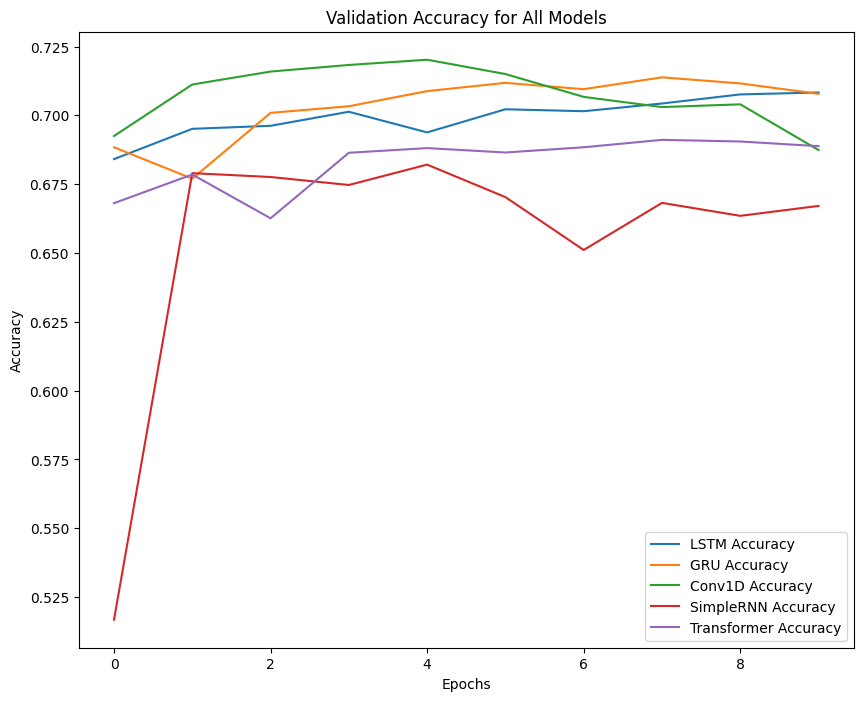

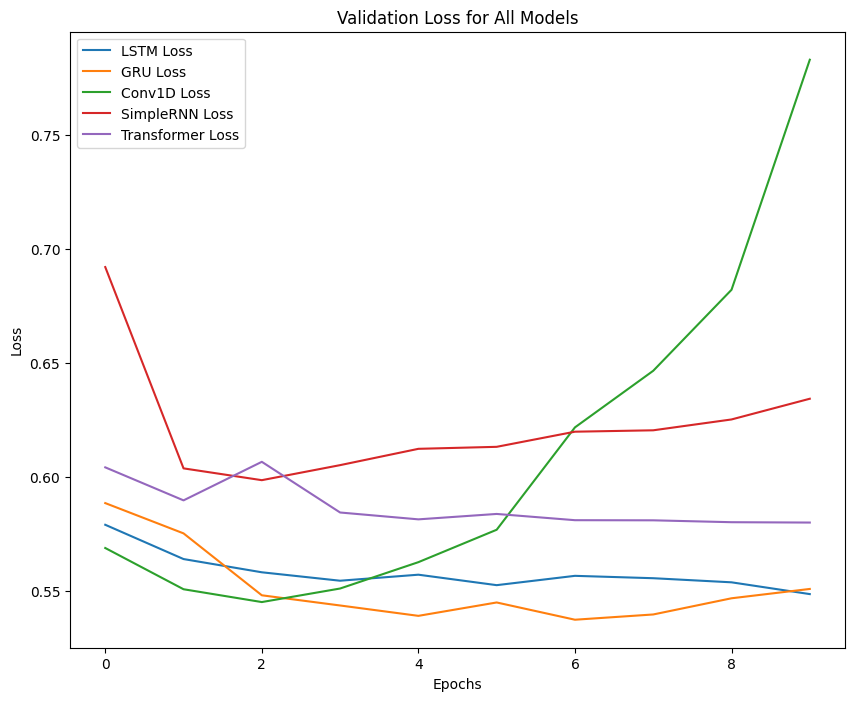

In [71]:
def plot_validation_metrics(model_histories, metric):
    plt.figure(figsize=(10, 8))

    for model_type, history in model_histories.items():
        val_metric = 'val_' + metric
        plt.plot(history.history[val_metric], label=f'{model_type} {metric.capitalize()}')

    plt.title(f'Validation {metric.capitalize()} for All Models')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.show()

# Plotting validation accuracy for all models
plot_validation_metrics(model_histories, 'accuracy')

# Plotting validation loss for all models
plot_validation_metrics(model_histories, 'loss')

## Function to use the best model on a new set of reviews

In [72]:
def get_reviews_and_predictions(file_path, tokenizer, model, maxlen):
    # Read new sentences (reviews) from the file
    with open(file_path, 'r', encoding='utf-8') as file:
        new_sentences = file.readlines()
    new_sentences = [sentence.strip() for sentence in new_sentences]

    # Convert the new reviews to sequences and pad them
    new_sequences = [tokenizer.encode(sentence) for sentence in new_sentences]
    new_reviews_padded = pad_sequences(new_sequences, maxlen=maxlen, padding='post', truncating='post')

    # Predict classes using the model
    predictions = model.predict(new_reviews_padded)

    # Combine reviews with their predicted sentiment scores
    reviews_with_predictions = list(zip(new_sentences, predictions.flatten()))

    return reviews_with_predictions

## Application of the model on a .txt file containing new reviews

In [77]:
# Get reviews and predictions
file_path = '/content/drive/My Drive/Positive_or_Negative/new_reviews.txt'
reviews_predictions = get_reviews_and_predictions(file_path, tokenizer, best_model, max_length)

# Sort the reviews by their predicted sentiment scores (from most positive to least)
sorted_reviews_predictions = sorted(reviews_predictions, key=lambda x: x[1], reverse=True)

# Print the sorted reviews with their scores and explicit sentiment
for review, score in sorted_reviews_predictions:
    sentiment = "Positive" if score > 0.494 else "Negative"
    print(f"Review: {review}\nPredicted Sentiment Score: {score} ({sentiment})\n")


1/1 [==============================] - 0s 99ms/step
Review: The character development was lacking and the plot was predictable.
Predicted Sentiment Score: 0.49593523144721985 (Positive)

Review: A heartwarming story that will make you laugh and cry.
Predicted Sentiment Score: 0.494768351316452 (Positive)

Review: Failed to meet expectations with its underdeveloped storyline and flat characters.
Predicted Sentiment Score: 0.49472522735595703 (Positive)

Review: A delightful comedy that’s perfect for a light-hearted evening.
Predicted Sentiment Score: 0.4944135546684265 (Positive)

Review: A thrilling adventure that keeps you on the edge of your seat.
Predicted Sentiment Score: 0.49417996406555176 (Positive)

Review: An insightful documentary that sheds light on an important issue.
Predicted Sentiment Score: 0.49404919147491455 (Positive)

Review: An innovative plot with unexpected twists and deep character exploration.
Predicted Sentiment Score: 0.49380478262901306 (Negative)

Review: A